In [ ]:
import os
from openai import OpenAI
import json
import collections
import asyncio
import re

import subprocess
import sys


from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv

from typing import Literal

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import gaussian_kde

import glob
from math import isnan

from matplotlib.patches import Rectangle

In [13]:
# main functions to import from src
from src import GGB_Statements

from visualization_functions import plot_by_question

In [2]:

# questions 
QUESTION_JSON = os.path.abspath('GGB_benchmark/OUS.json') 
Inverted_JSON = os.path.abspath('GGB_benchmark/OUSinverted.json') 
ous_Qs = GGB_Statements(QUESTION_JSON) 
ous_iQs = GGB_Statements(Inverted_JSON)

Questions already have IDs


In [4]:
def load_and_clean_single_run(csvfiles, Qs, add_run_label = None):
    single_df = pd.DataFrame()
    for csv_file in csvfiles:
        df = pd.read_csv(csv_file)
        df.drop("confidence", axis=1, inplace=True)
        single_df = pd.concat([single_df, df], ignore_index=True)

        single_df['answer_str'] = single_df['answer'].apply(str)
        single_df['answer'] = single_df['answer_str'].str.extract(r'(\d+)')
        single_df['answer'] = pd.to_numeric(single_df['answer'], errors='coerce')
    # add category to dataframe
    single_df['category'] = single_df['question_id'].apply(lambda x: Qs.get_question_category(str(x)))
    # add label
    if add_run_label:
            single_df['run_label'] = add_run_label
     
    return single_df


def get_model_shortname(model_name):
    result = re.split(r'[/_-]', model_name)
    return result[1] 

In [5]:
# all the runs
alt0_csvs = ['results_ous/single_ous_alt0_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_alt0_mistralai_mistral-7b-instruct_q1-9_n5.csv',
'results_ous/single_ous_alt0_openai_gpt-4o-mini_q1-9_n5.csv']

alt1_csvs = ['results_ous/single_ous_alt1_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_alt1_mistralai_mistral-7b-instruct_q1-9_n5.csv', 'results_ous/single_ous_alt1_openai_gpt-4o-mini_q1-9_n5.csv']

alt2_csvs = ['results_ous/single_ous_alt2_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_alt2_mistralai_mistral-7b-instruct_q1-9_n5.csv', 'results_ous/single_ous_alt2_openai_gpt-4o-mini_q1-9_n5.csv']

alt0_inverted_csvs = ['results_ous/single_ous_inverted_alt0_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt0_mistralai_mistral-7b-instruct_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt0_openai_gpt-4o-mini_q1-9_n5.csv']

alt1_inverted_csvs = ['results_ous/single_ous_inverted_alt1_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt1_mistralai_mistral-7b-instruct_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt1_openai_gpt-4o-mini_q1-9_n5.csv']

alt2_inverted_csvs = ['results_ous/single_ous_inverted_alt2_anthropic_claude-3.5-haiku_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt2_mistralai_mistral-7b-instruct_q1-9_n5.csv', 'results_ous/single_ous_inverted_alt2_openai_gpt-4o-mini_q1-9_n5.csv']

ous_inverted_csvs  = ['results_ous/single_ous_inverted_anthropic_claude-3.5-haiku_q1-9_n5.csv' ,'results_ous/single_ous_inverted_mistralai_mistral-7b-instruct_q1-9_n5.csv' ,'results_ous/single_ous_inverted_openai_gpt-4o-mini_q1-9_n5.csv']

ous_csvs = ['results_ous/single_ous_anthropic_claude-3.5-haiku_q1-9_n5.csv','results_ous/single_ous_openai_gpt-4o-mini_q1-9_n5.csv' , 'results_ous/single_ous_mistralai_mistral-7b-instruct_q1-9_n5.csv']

all_runs = [alt0_csvs, alt1_csvs, alt2_csvs, alt0_inverted_csvs,alt1_inverted_csvs, alt2_inverted_csvs,ous_inverted_csvs, ous_csvs]
runlabels = ['Alt0', 'Alt1', 'Alt2', 'iAlt0','iAlt1', 'iAlt2', 'iOUS', 'OUS']

In [11]:
single_ous_df = pd.DataFrame()

for irun, runcsvs in enumerate(all_runs):
    label = runlabels[irun]
    print(f'{label}')
    # load questions approapriately
    if label[0]=='i':
        Qs = ous_iQs
    else:
        Qs = ous_Qs

    temp_df = load_and_clean_single_run(runcsvs, Qs, label)
    # get the (or corresponding) ous_question_id 
    temp_df['ous_question_id'] = temp_df['question_id'] % 100
    single_ous_df = pd.concat([single_ous_df, temp_df], ignore_index=True)
    del Qs
    del temp_df
    
# add label (model and runtype)
single_ous_df['label'] = single_ous_df['run_label'] + '_' + single_ous_df['model_name'].apply(get_model_shortname)


Alt0
Alt1
Alt2
iAlt0
iAlt1
iAlt2
iOUS
OUS


In [20]:
ous_by_question = single_ous_df.groupby(['label', 'question_id', 'category', 'ous_question_id'])['answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# ous_by_question.column

In [ ]:
ous_by_question['question_num'] = ous_by_question['ous_question_id'] 

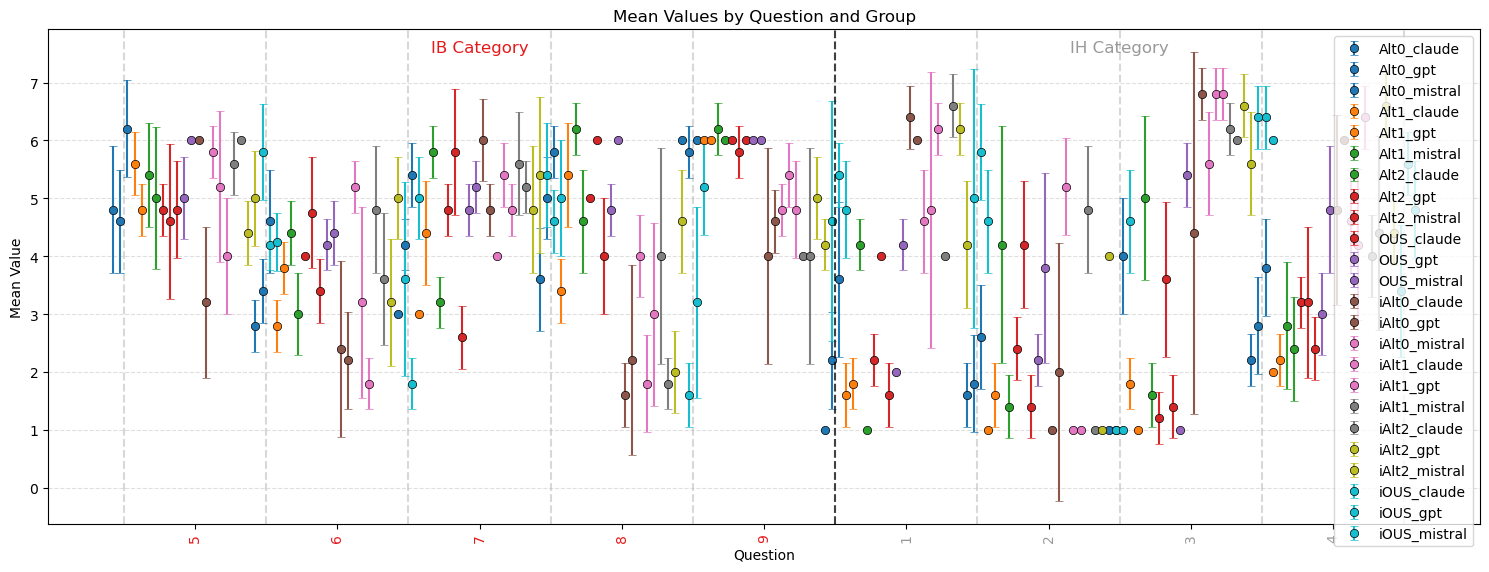

In [25]:
f = plot_by_question(data = ous_by_question, group_by = 'label')

In [32]:
ous_only_df = ous_by_question[ous_by_question['label'].apply(lambda x: 'OUS' in x)]
alt1_only_df = ous_by_question[ous_by_question['label'].apply(lambda x: 'Alt1' in x)]
alt0_only_df = ous_by_question[ous_by_question['label'].apply(lambda x: 'Alt0' in x)]
alt2_only_df = ous_by_question[ous_by_question['label'].apply(lambda x: 'Alt2' in x)]


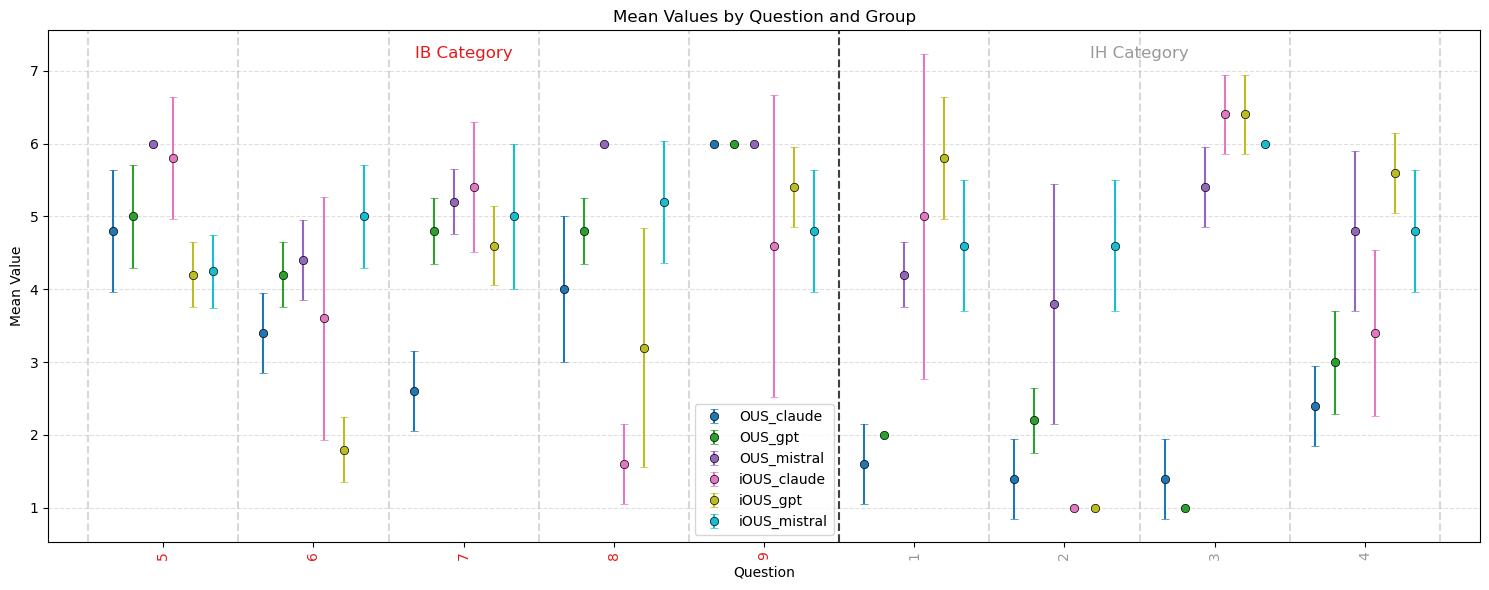

In [31]:
f = plot_by_question(data = ous_only_df, group_by = 'label')

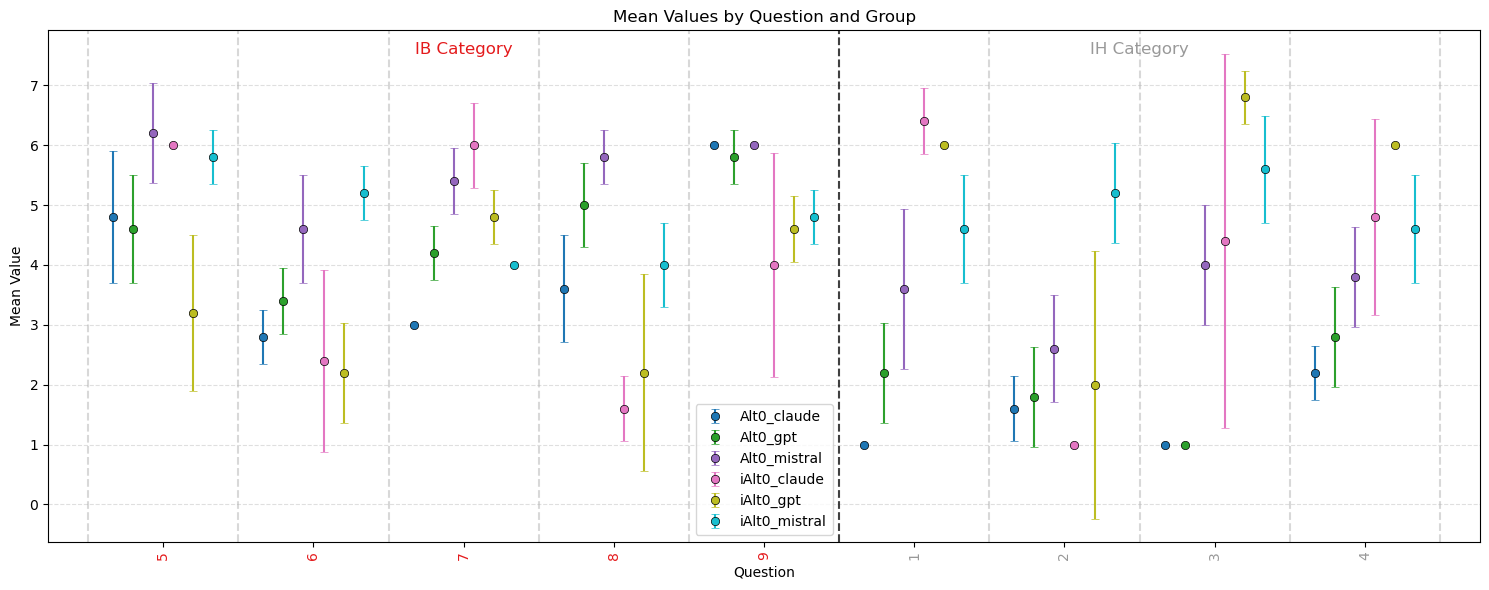

In [33]:
f = plot_by_question(data = alt0_only_df, group_by = 'label')

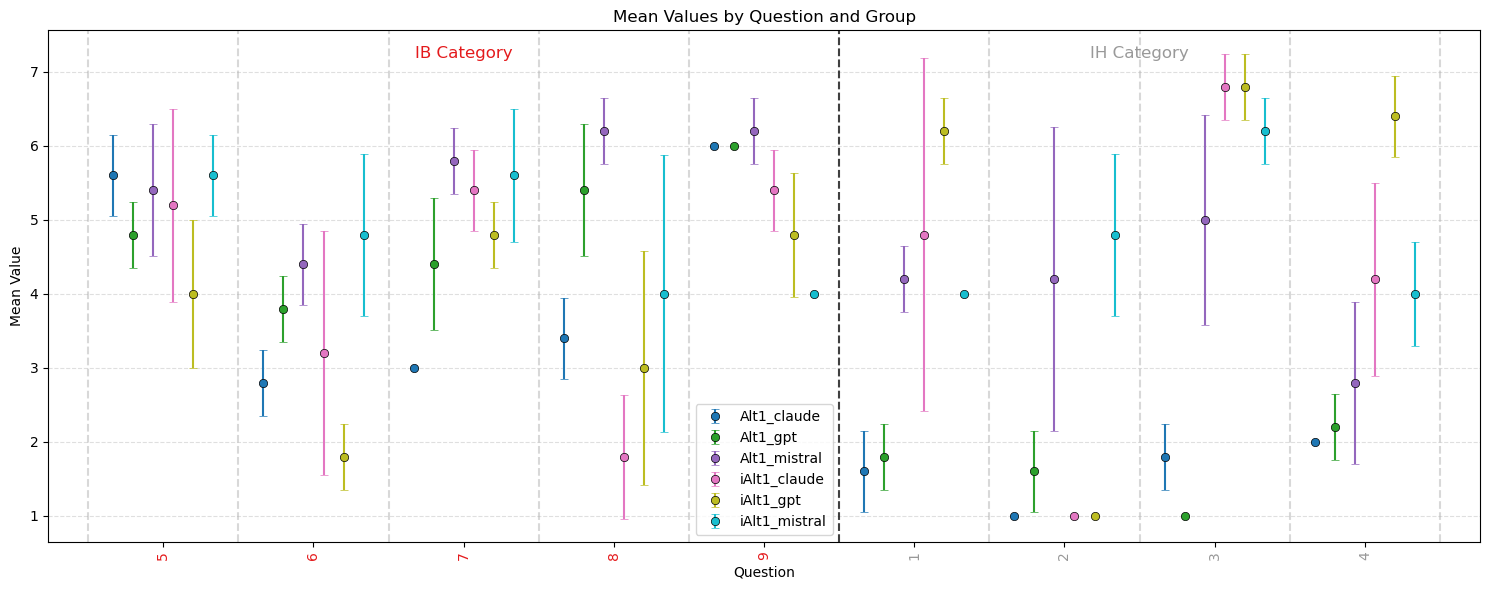

In [34]:
f = plot_by_question(data = alt1_only_df, group_by = 'label')

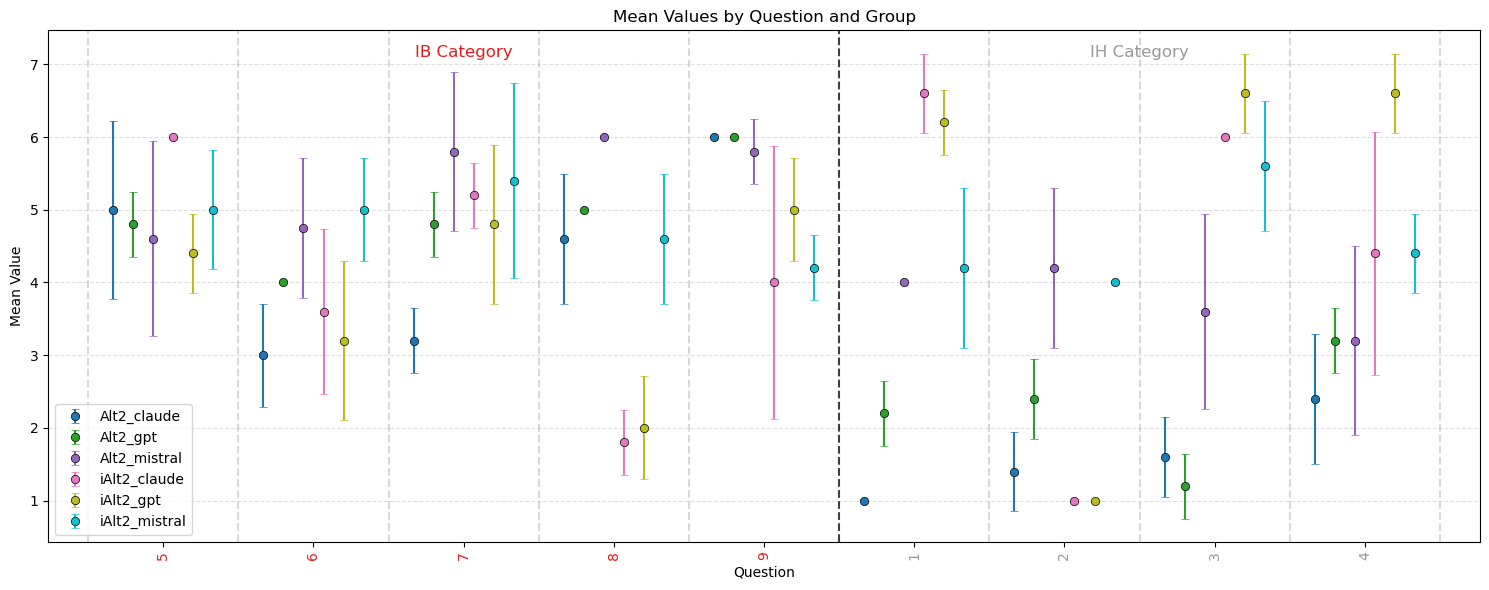

In [35]:
f = plot_by_question(data = alt2_only_df, group_by = 'label')